In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
import numpy as np
import math
try:
    import _pickle as cPickle
except:
    import cPickle
import tensorflow as tf
import time
import os
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
import tarfile
import zipfile
import sys

In [23]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [24]:
def  plot_imagesplot_im(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [25]:
def getProgressBar(accuracy):
    percentage = int(round((accuracy)*100))
    progress_bar_size = 25
    completed = int((progress_bar_size*int(percentage))/100)
    progress_bar = '=' * completed + '>' + '-' * (progress_bar_size - completed)
    return progress_bar, percentage

In [26]:
def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()


def downloadDataSetIfNotPresent():
    main_directory = os.path.join(os.getcwd(), 'data')
    
    cifar_10_directory = os.path.join(main_directory, 'cifar-10-batches-py')
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)

        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        zip_cifar_10 = os.path.join(main_directory, filename)
        file_path, _ = urlretrieve(url=url, filename=zip_cifar_10, reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        os.remove(zip_cifar_10)

In [27]:
def unpickle(file_name):
    with open(file_name, 'rb') as fo:
        dict = {}
        try:
            dict = cPickle.load(fo, encoding='latin1')
        except:
            dict = cPickle.load(fo)
    return dict

In [28]:
def readCIFARData():
    x = None
    y = None
    downloadDataSetIfNotPresent()
    for batch_no in range(1,6,1):
        data_dict = unpickle("data/cifar-10-batches-py/data_batch_%d"%batch_no)
        if batch_no == 1:
            x = data_dict['data']
            y = data_dict['labels']
        else:
            x = np.append(x, data_dict['data'], axis=0)
            y = np.append(y, data_dict['labels'], axis=0)
    return x, y

def preprocessData(x):
    mu = np.mean(x, axis=0)
    mu = mu.reshape(1,-1)
    sigma = np.std(x, axis=0)
    sigma = sigma.reshape(1, -1)
    x = x - mu
    x = x / sigma
    return x

In [29]:
def weight_variable(shape):
    print(shape)
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(length):
    initial = tf.constant(0.1, shape=[length], dtype=tf.float32)
    return tf.Variable(initial)

In [30]:
def createConvulationalLayer(input_data, channel_count, filter_size, filter_count, max_pooling=True):
    shape = [filter_size, filter_size, channel_count, filter_count]
    weights = weight_variable(shape=shape)
    bias = bias_variable(length=filter_count)
    layer = tf.nn.conv2d(input=input_data,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += bias
    if max_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = tf.layers.dropout(layer, rate=0.25)
    layer = tf.nn.relu(layer)
    return layer, weights

In [31]:
def createFlattenLayer(layer):
    layer_shape = layer.get_shape()
    # layer_shape is assumed to be in shape [number_of_images, image_height, image_width, channels]
    # The channels will be the number of fiter_count in the previous layer
    feature_count = layer_shape[1:4].num_elements()
    layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(layer, [-1, feature_count])
    return flat_layer, feature_count

In [32]:
def createFullyConnectedLayer(input_data, input_feature_count, output_feature_count, apply_relu=False):
    weights = weight_variable(shape=[input_feature_count, output_feature_count])
    bias = bias_variable(length=output_feature_count)
    layer = tf.matmul(input_data, weights) + bias
    if apply_relu:
        layer = tf.nn.relu(layer)
    return layer

In [33]:
x_data_raw, y_data_raw = readCIFARData()
x_data = preprocessData(x_data_raw)
y_labels = np.array(unpickle("data/cifar-10-batches-py/batches.meta")['label_names'])

In [34]:
image_depth = 3
image_height = 32
image_width = 32

image_shape = (image_height, image_width, image_depth)

In [35]:
x_data_raw = x_data_raw.reshape([-1, image_depth, image_height, image_width])
x_data_raw = x_data_raw.transpose([0, 2, 3, 1])

In [36]:
n_samples = x_data.shape[0]
x_data = x_data.reshape([-1, image_depth, image_height, image_width])
x_data = x_data.transpose([0, 2, 3, 1])

category_count = len(y_labels)
y_data_labels = [y_labels[x] for x in y_data_raw]

In [37]:
y_data = np.zeros((n_samples, category_count))
for i in range(n_samples):
    y_data[i][y_data_raw[i]] = 1

In [38]:
x_train = x_data[:-10000]
y_train = y_data[:-10000]

x_test = x_data[40000:]
y_test = y_data[40000:]

In [39]:
filter_size_2 = 2
filter_size_3 = 3
filter_size_5 = 5
filter_count_32 = 32
filter_count_64 = 64
filter_count_128 = 128

fully_conn_layer_1_out_size = 128
fully_conn_layer_2_out_size = category_count

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 32, 32, 3)


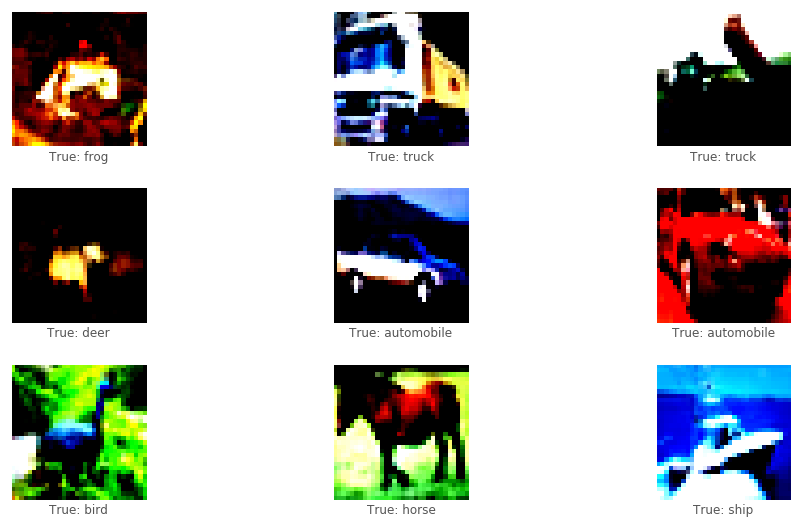

In [40]:
print(x_data[:10].shape)
plot_imagesplot_im(x_data[:10], y_data_labels[:10])

In [41]:
x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_depth])
y_actual = tf.placeholder(tf.float32, shape=(None, category_count))

In [42]:
conv_layer_1, conv_weights_1 = createConvulationalLayer(input_data=x,
                   channel_count=image_depth,
                   filter_size=filter_size_3,
                   filter_count=filter_count_32,
                   max_pooling=False)

[3, 3, 3, 32]


In [43]:
conv_layer_2, conv_weights_2 = createConvulationalLayer(input_data=conv_layer_1,
                   channel_count=filter_count_32,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=True)

[3, 3, 32, 64]


In [44]:
conv_layer_3, conv_weights_3 = createConvulationalLayer(input_data=conv_layer_2,
                   channel_count=filter_count_64,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=False)

[3, 3, 64, 128]


In [45]:
conv_layer_4, conv_weights_4 = createConvulationalLayer(input_data=conv_layer_3,
                   channel_count=filter_count_128,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=True)

[3, 3, 128, 128]


In [46]:
conv_layer_5, conv_weights_5 = createConvulationalLayer(input_data=conv_layer_4,
                   channel_count=filter_count_128,
                   filter_size=filter_size_3,
                   filter_count=filter_count_128,
                   max_pooling=False)

[3, 3, 128, 128]


In [47]:
flat_layer, num_features = createFlattenLayer(conv_layer_5)

In [48]:
fully_con_layer_1 = createFullyConnectedLayer(input_data=flat_layer,
                         input_feature_count=num_features,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

[8192, 128]


In [49]:
fully_con_layer_2 = createFullyConnectedLayer(input_data=fully_con_layer_1,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

[128, 128]


In [50]:
fully_con_layer_3 = createFullyConnectedLayer(input_data=fully_con_layer_2,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_2_out_size,
                         apply_relu=False)

[128, 10]


In [51]:
y_predicted = tf.nn.softmax(fully_con_layer_3)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(y_predicted), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [52]:
is_correct = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [53]:
epochs = 100
batch_size = 128
total_batches = int(x_train.shape[0] / batch_size)
print("Total batches are ", total_batches)

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
session.run(init)

highest_test_accuracy = 0
highest_train_accuracy = 0
train_ac, test_ac = 0, 0
training_done = False

Total batches are  312


In [ ]:
start_time = time.time()
for i in range(epochs):
    if training_done:
        break
    for batch_no in range(total_batches):
        start_index = batch_no * batch_size
        end_index = (batch_no + 1) * batch_size
        batch_X = x_train[start_index:end_index]
        batch_Y  = y_train[start_index:end_index]

        train_data = {x: batch_X, y_actual: batch_Y}
        
        indices = np.random.choice(10000, 256)
        test_batch_X = x_train[indices]
        test_batch_Y  = y_train[indices]
        test_data = {x: test_batch_X, y_actual: test_batch_Y}

        # Training Step
        session.run(optimizer, feed_dict=train_data)
        
        end_time = time.time()
        # Calculate accuracy of the model on the training data in the current epoch
        train_ac = session.run(accuracy, feed_dict=train_data)
        test_ac = session.run(accuracy, feed_dict=test_data)
        
        if train_ac > highest_train_accuracy or test_ac > highest_test_accuracy:
            highest_train_accuracy = max(train_ac, highest_train_accuracy)
            highest_test_accuracy = max(test_ac, highest_test_accuracy)
            
            train_p_bar, train_percent = getProgressBar(highest_train_accuracy)
            test_p_bar, test_percent = getProgressBar(highest_test_accuracy)

            msg = "Iteration:{:>3} - [{}] {:>3}% -Train Acc | [{}] {:>3}% -Test Acc"
            print(msg.format(i, train_p_bar, train_percent, test_p_bar, test_percent))
            if highest_train_accuracy == 1.0:
                training_done = True
                break
            
print("Training done in %f mins"%((time.time() - start_time)/60))

In [57]:
dirs = [os.path.join(os.getcwd(), 'model'), os.path.join(os.getcwd(), 'logs')]
for dir_t in dirs:
    if not os.path.exists(dir_t):
        os.makedirs(dir_t)

In [55]:
if False:
    saver = tf.train.Saver()
    save_path = saver.save(session, os.path.join(model, "model.ckpt"))
    print("Model saved in path: %s" % save_path)

In [56]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, os.path.join(model, "model.ckpt"))

INFO:tensorflow:Restoring parameters from /home/amit/notebooks/model/model.ckpt


In [62]:
writer = tf.summary.FileWriter(dirs[1], graph=tf.get_default_graph())

In [37]:
def getActivations(layer, image):
    test_data = {x: image}
    units = sess.run(layer,feed_dict=test_data)
    plotNNFilter(units)

In [38]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

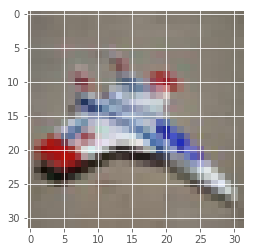

In [46]:
image_index = 30
imageToUse = x_data_raw[image_index]
plt.imshow(imageToUse, interpolation="nearest", cmap="gray")
imageToUse = x_data[image_index]

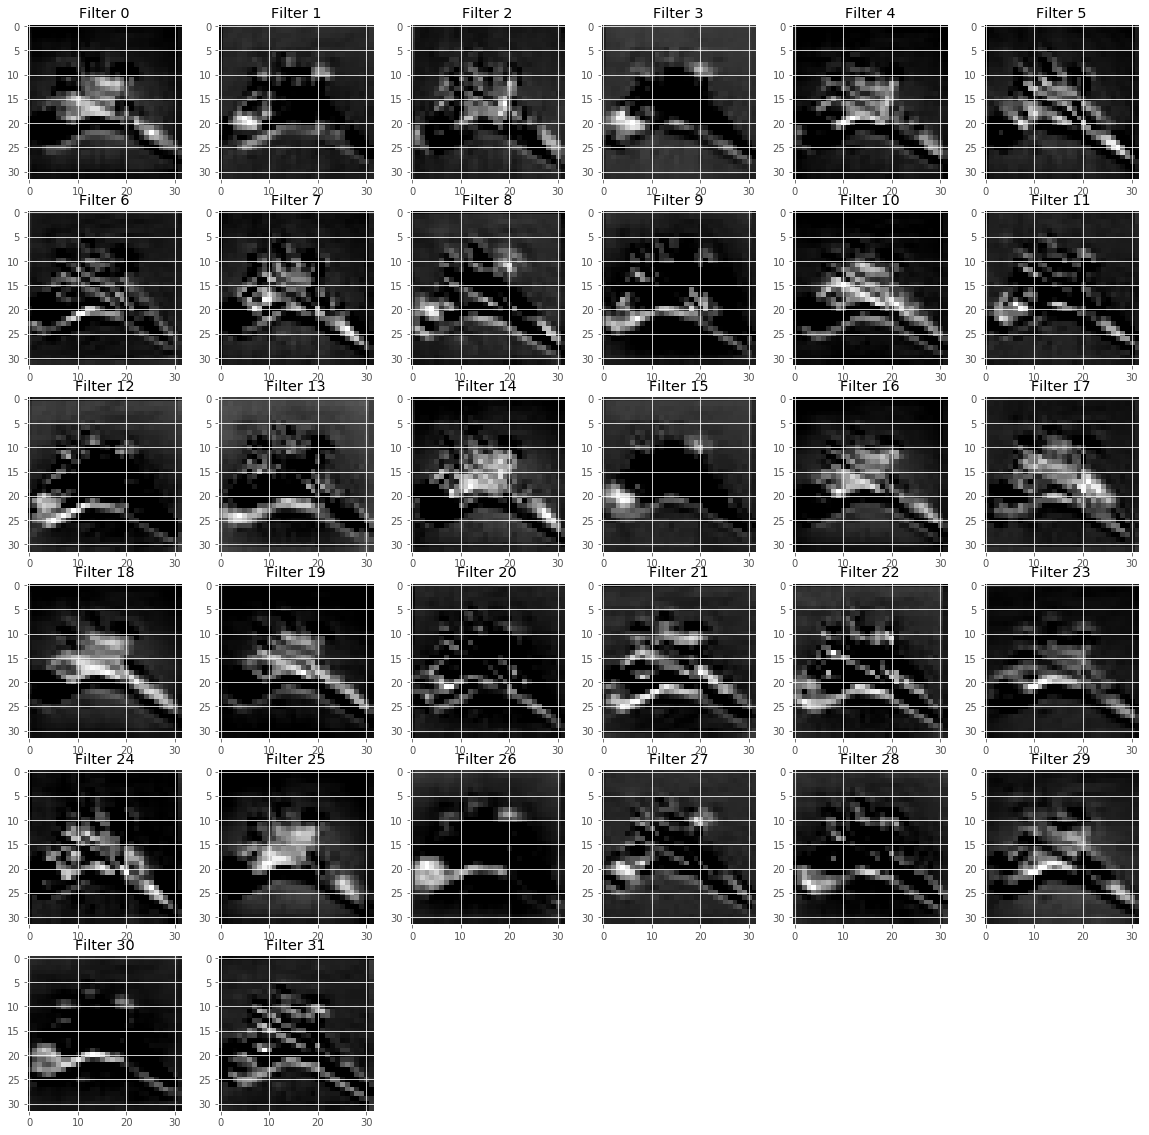

In [47]:
getActivations(conv_layer_1,[imageToUse])

In [60]:
def predict(image, actual_labels=''):
    test_data = {x: image}
    predictions = sess.run(y_predicted, feed_dict=test_data)
    predicted_labels = y_labels[np.argmax(predictions, axis=1)]
    print('Predicted'.ljust(15) + 'Actual')
    for i in range(len(predicted_labels)):
        print(predicted_labels[i].ljust(15)+ actual_labels[i].ljust(15)+ 'Correct' if predicted_labels[i] == actual_labels[i] else "Wrong")
        

In [61]:
predict(x_data[40000:40010], y_data_labels[40000:40010])

Predicted      Actual
automobile     automobile     Correct
ship           ship           Correct
dog            dog            Correct
automobile     automobile     Correct
Wrong
horse          horse          Correct
deer           deer           Correct
cat            cat            Correct
ship           ship           Correct
Wrong
